In [1]:
%pip install pulp
%pip install scipy
import pulp
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 20.3 MB/s eta 0:00:00


In [2]:
import pulp

# Create a linear programming problem
model = pulp.LpProblem("Battery_Optimization", pulp.LpMinimize)

# Battery Data
B_max = 15  # kWh
P_charge_max = 5  # kW
P_discharge_max = 5  # kW
G_max = 100  # kWh
G_min = -100
B_t_minus_1 = 2


# Decision Variables
G = pulp.LpVariable.dicts("Grid", range(2), 0, G_max) # Net demand from the grid
B = pulp.LpVariable.dicts("Battery_Charge", range(2), 0, B_max)  # Battery state of charge
P_charge = pulp.LpVariable.dicts("Charging_Power", range(2), 0, P_charge_max)  # Charging power
P_discharge = pulp.LpVariable.dicts("Discharging_Power", range(2), 0, P_discharge_max)  # Discharging power
#G_export = pulp.LpVariable.dicts("Discharged_Energy", range(24), G_min, 0)


# Data for t1 and t2
L = [3, 5]  # Load in kW for t1 and t2
S = [1, 1]  # Solar Generation in kW for t1 and t2
n = [0.10, 0.30]  # Cost of energy Import ($/kWh) for t1 and t2
m = [0, 0]  # Cost of energy Export ($/kWh) for t1 and t2

# Objective Function
model += pulp.lpSum([(n[t] * G[t]) for t in range(2)])

for t in range(1, 2):
    model += B[t] == B[t-1] + (P_charge[t-1] - P_discharge[t-1])

for t in range(2):
    model += B[0] == 2  # Set the initial state of charge
    model += B[t] + (P_charge[t] - P_discharge[t]) <= B_max
    model += P_charge[t] <= P_charge_max
    model += P_discharge[t] <= P_discharge_max
    model += P_discharge[t] <= B_max - B[t]
    model += G[t] == L[t] - S[t] + (P_charge[t] - P_discharge[t])

# Solve the linear program
model.solve()

# Get the optimal electricity cost
optimal_cost = pulp.value(model.objective)
optimal_B = [pulp.value(B[t]) for t in range(2)]
optimal_P_charge = [pulp.value(P_charge[t]) for t in range(2)]
optimal_P_discharge = [pulp.value(P_discharge[t]) for t in range(2)]

# Print the optimal cost
print("Optimal Electricity Cost: $",optimal_cost)
print("Optimal Battery Behavior (kWh):", optimal_B)
print("Optimal Discharge (kW):", optimal_P_discharge)
print("Optimal Charge (kW):", optimal_P_charge)


Optimal Electricity Cost: $ 0.0
Optimal Battery Behavior (kWh): [2.0, 0.0]
Optimal Discharge (kW): [2.0, 4.0]
Optimal Charge (kW): [0.0, 0.0]


In [3]:
import numpy as np
from scipy.optimize import linprog

#Objective function
f = [0, 0, 0, 0, 0, 0, 0.1, 0.3, 0, 0, 0, 0]

#Inequality constraints
A = [
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # pc1 <= 5
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # pc2 <= 5
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # pd1 <= 5
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # pd2 <= 5
    [1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0],  # b1+pc1-pd1 <= 15
    [0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0],  # b2+pc2-pd2 <= 15
    [-1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # pd1 <= b1
    [0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]   # pd2 <= b2
]

b = [5, 5, 5, 5, 15, 15, 0, 0]

#Equality constraints
Aeq = [
    [1, -1, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0],    # b2 = b1+pc1-pd1
    [0, 0, 1, 0, -1, 0, -1, 0, 1, 0, -1, 0],  # E1 = L1-S1 + pc1-pd1
    [0, 0, 0, 1, 0, -1, 0, -1, 0, 1, 0, -1]   # E2 = L2-S2 + pc2-pd2
]

#Equality constraints
beq = [0, 0, 0]

ub = [2, 15, 5, 5, 5, 5, 100, 100, 3, 5, 1, 1]
lb = [2, 0, 0, 0, 0, 0, 0, 0, 3, 5, 1, 1]

result = linprog(f, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=list(zip(lb, ub)))

optimal_sol = result.x
optimal_obj = result.fun

print("Optimal Solution:", optimal_sol)
print("Optimal Price:", optimal_obj)


Optimal Solution: [2. 4. 2. 0. 0. 4. 4. 0. 3. 5. 1. 1.]
Optimal Price: 0.4


In [4]:
for t in range(2):
    model += B[0] == 2  # Set the initial state of charge
    model += B[t] + (P_charge[t] - P_discharge[t]) <= B_max
    model += P_charge[t] <= P_charge_max
    model += P_discharge[t] <= P_discharge_max
    model += P_discharge[t] <= B[t]
    model += G[t] == L[t] - S[t] + (P_charge[t] - P_discharge[t])


Optimal Electricity Cost for Customers: 1.4926665000000006
Optimal Battery Behavior (kWh): [2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0819092, 0.72253023, 0.48376841, 1.3353098, 3.3470825, 5.8113281, 8.1883107, 10.548311, 12.381365, 13.30958, 13.210735, 11.306023, 8.1062738, 4.2, 0.0, 0.0, 0.0, 0.0]
Optimal Grid Energy Flows (kWh): [2.82, 0.55, 2.43, 2.37, 2.3562506, 4.2970794, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.23, 4.02, 3.6, 3.18]
Optimal Discharge (kW): [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.3593789, 0.23876182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.098844642, 1.9047117, 3.1997496, 3.9062738, 4.2, 0.0, 0.0, 0.0, 0.0]
Optimal Charge (kW): [0.0, 0.0, 0.0, 0.0, 0.0, 2.0819092, 0.0, 0.0, 0.85154136, 2.0117727, 2.4642457, 2.3769825, 2.36, 1.8330538, 0.92821517, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


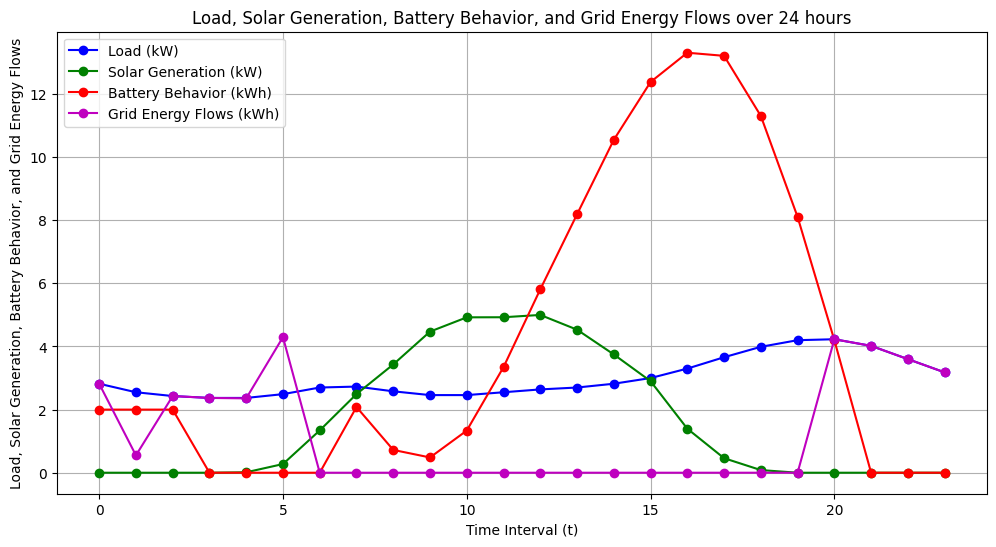

In [6]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

#Loading data from the Excel file
df = pd.read_excel('residential_electricity_data (1).xlsx')

#Extracting data into lists or dictionaries
t = df['Hour'].tolist()
L = df['Load (kW)'].tolist()
S = df['Solar Generation (kW)'].tolist()
n = df['Cost of energy Import ($/kWh)'].tolist()
m = df['Value of energy export ($/kWh)'].tolist()

#A dictionary to map time intervals to their corresponding data
data = {t_val: {'L': L_val, 'S': S_val, 'n': n_val, 'm': m_val} for t_val, L_val, S_val, n_val, m_val in zip(t, L, S, n, m)}

# Create a linear programming problem
model = pulp.LpProblem("Battery_Optimization", pulp.LpMinimize)

B_max = 15
P_charge_max = 5
P_discharge_max = 5
E_max = 100

# Decision Variables
E = pulp.LpVariable.dicts("Grid", range(24), 0, E_max)
B = pulp.LpVariable.dicts("Battery_Charge", range(24), 0, B_max)  # Battery state of charge
P_charge = pulp.LpVariable.dicts("Charging_Power", range(24), 0, P_charge_max)  # Charging power
P_discharge = pulp.LpVariable.dicts("Discharging_Power", range(24), 0, P_discharge_max)  # Discharging power
#E_export = pulp.LpVariable.dicts("Exported_Energy", range(24), -E_max, 0)


# Objective Function
model += pulp.lpSum([(n[t] - m[t]) * E[t] for t in range(24)])

# Constraints
for t in range(1,24):
    model += B[t] == B[t-1] + (P_charge[t-1] - P_discharge[t-1])

for t in range(24):
    model += B[0] == 2  # Set the initial state of charge
    model += B[t] + (P_charge[t] - P_discharge[t]) <= B_max
    model += P_charge[t] <= P_charge_max
    model += P_discharge[t] <= P_discharge_max
    model += P_discharge[t] <= B[t]
    model += E[t] == L[t] - S[t] + (P_charge[t] - P_discharge[t]) #if L[t] > S[t] else E_export[t] == 0


#Solve LP
model.solve()

#Optimal electricity cost
optimal_cost = pulp.value(model.objective)

#Print the optimal cost
print("Optimal Electricity Cost for Customers:", optimal_cost)

#optimal battery behavior and grid energy flows for 24 hours
optimal_B = [pulp.value(B[t]) for t in range(24)]
optimal_P_charge = [pulp.value(P_charge[t]) for t in range(24)]
optimal_P_discharge = [pulp.value(P_discharge[t]) for t in range(24)]
optimal_E = [pulp.value(E[t]) for t in range(24)]


# Initial state of charge
initial_soc = 2

# Create a time vector
time_vector = range(24)

# Plot the data
plt.figure(figsize=(12, 6))

# Plot load and solar generation
plt.plot(time_vector, L, label='Load (kW)', marker='o', linestyle='-', color='b')
plt.plot(time_vector, S, label='Solar Generation (kW)', marker='o', linestyle='-', color='g')

# Plot battery behavior and grid energy flows
print("Optimal Battery Behavior (kWh):", optimal_B)
print("Optimal Grid Energy Flows (kWh):", optimal_E)
print("Optimal Discharge (kW):", optimal_P_discharge)
print("Optimal Charge (kW):", optimal_P_charge)

plt.plot(time_vector, [initial_soc] + optimal_B[:23], label='Battery Behavior (kWh)', marker='o', linestyle='-', color='r')
plt.plot(time_vector, optimal_E, label='Grid Energy Flows (kWh)', marker='o', linestyle='-', color='m')

plt.xlabel('Time Interval (t)')
plt.ylabel('Load, Solar Generation, Battery Behavior, and Grid Energy Flows')
plt.title('Load, Solar Generation, Battery Behavior, and Grid Energy Flows over 24 hours')
plt.legend()

plt.grid(True)
plt.show()
